In [125]:
#importing the needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Question 1

In [126]:
# part a 

# Given coefficients and values
beta_0 = -4.2
beta_1 = 0.04
beta_2 = 0.8
x1 = 60  # coding hours
x2 = 2   # years of experience

# Compute the linear predictor
z = beta_0 + beta_1 * x1 + beta_2 * x2

# Compute the logistic function
probability = 1 / (1 + math.exp(-z))
print(f"Estimated probability of admission: {probability:.4f}")


Estimated probability of admission: 0.4502


In [127]:
# part b

# Given values from part a used here as well
target_probability = 0.9

# Step 1: Compute z from the logistic function for target probability
z = math.log(target_probability / (1 - target_probability))  # inverse of logistic function

# Step 2: Solve for x1
# z = beta_0 + beta_1 * x1 + beta_2 * x2
# => x1 = (z - beta_0 - beta_2 * x2) / beta_1
new_x1 = (z - beta_0 - beta_2 * x2) / beta_1

print(f"Required practice hours for 90% chance of admission: {new_x1:.2f}")


Required practice hours for 90% chance of admission: 119.93


## part c

In the context of this model, “β0 = −4.2” would be the log odds that an applicant is admitted to the bootcamp while having 0 hours of coding practice completed and 0 years of programming experience. Log odds is different from probability, but from it we can calculate the probability of an applicant with these credentials getting into the bootcamp.

# Question 2

In [128]:
#Loading the orange juice data

from ISLP import load_data
OJ = load_data('OJ')
OJ

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,Yes,0.000000,0.053763,0.23,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,Yes,0.112676,0.000000,0.27,0


In [129]:
#Create the Train and Test subsets
train = OJ[OJ['StoreID'].isin([1, 2, 3, 4])].copy()
test = OJ[OJ['StoreID'] == 7].copy()

In [130]:
#part a

#Find the variables from the Train dataset
selected_vars = train[['LoyalCH', 'SpecialCH', 'PriceDiff']]

#Compute the statistics it told us to
summary_stats = selected_vars.agg(['mean', 'std', 'median', 'min', 'max'])

print(summary_stats)

         LoyalCH  SpecialCH  PriceDiff
mean    0.519988   0.046218   0.114524
std     0.313757   0.210105   0.255935
median  0.500000   0.000000   0.200000
min     0.000011   0.000000  -0.670000
max     0.999947   1.000000   0.440000


In [131]:
#part b

#we already have the selected_vars from above

#make the correlation matrix
correlation_matrix = selected_vars.corr()

print(correlation_matrix)

            LoyalCH  SpecialCH  PriceDiff
LoyalCH    1.000000   0.014230   0.008349
SpecialCH  0.014230   1.000000  -0.025542
PriceDiff  0.008349  -0.025542   1.000000


In [132]:
#part c

# Convert 'Purchase' to 0/1 (1 if CH, 0 if MM)
train['Purchase_bin'] = (train['Purchase'] == 'CH').astype(int)

#formula for logistic regression
formula = 'Purchase_bin ~ LoyalCH + SpecialCH + PriceDiff'

#Fit the logistic regression model
logit_model = smf.logit(formula=formula, data=train).fit()

# Step 4: Print the summary
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.414155
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Purchase_bin   No. Observations:                  714
Model:                          Logit   Df Residuals:                      710
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                  0.4009
Time:                        01:26:27   Log-Likelihood:                -295.71
converged:                       True   LL-Null:                       -493.55
Covariance Type:            nonrobust   LLR p-value:                 1.902e-85
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4069      0.267    -12.756      0.000      -3.930      -2.883
LoyalCH        6.3847      0.

## part c

LoyalCH and PriceDiff are statistically significant predictors of purchase. This is seen by p-values of 0 which is less than 0.05, meaning that both variables are statistically significant.

In [133]:
# part d

#predicted probabilities for Train data
train['pred_prob'] = logit_model.predict(train)

#apply 0.5 threshold
train['pred_class'] = (train['pred_prob'] >= 0.5).astype(int)

#Confusion matrix
cm = confusion_matrix(train['Purchase_bin'], train['pred_class'])

tn, fp, fn, tp = cm.ravel()  # True Neg, False Pos, False Neg, True Pos

#Compute metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
false_positive_rate = fp / (fp + tn) * 100  # % of actual MM predicted as CH
false_negative_rate = fn / (fn + tp) * 100  # % of actual CH predicted as MM

print("Confusion Matrix:")
print(cm)
print(f"\nOverall accuracy: {accuracy:.3f}")
print(f"False positive rate: {false_positive_rate:.2f}%")
print(f"False negative rate: {false_negative_rate:.2f}%")

Confusion Matrix:
[[269  66]
 [ 62 317]]

Overall accuracy: 0.821
False positive rate: 19.70%
False negative rate: 16.36%


In [134]:
# part e

# Refit logistic regression with only significant predictors
formula_reduced = 'Purchase_bin ~ LoyalCH + PriceDiff'
logit_model_reduced = smf.logit(formula=formula_reduced, data=train).fit()

#Prepare the Test set
test = OJ[OJ['StoreID'] == 7].copy()
test['Purchase_bin'] = (test['Purchase'] == 'CH').astype(int)

#Predict probabilities on Test set
test['pred_prob'] = logit_model_reduced.predict(test)

#Predict class with threshold = 0.5
test['pred_class'] = (test['pred_prob'] >= 0.5).astype(int)

#Compute confusion matrix
cm = confusion_matrix(test['Purchase_bin'], test['pred_class'])
tn, fp, fn, tp = cm.ravel()

#Compute performance metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
false_positive_rate = fp / (fp + tn) * 100
false_negative_rate = fn / (fn + tp) * 100

print("Reduced Logistic Model Summary (Train):")
print(logit_model_reduced.summary())

print("\nConfusion Matrix on Test Data:")
print(cm)

print(f"\nFraction of Correct Predictions: {accuracy:.3f}")
print(f"False Positive Percent: {false_positive_rate:.2f}%")
print(f"False Negative Percent: {false_negative_rate:.2f}%")

Optimization terminated successfully.
         Current function value: 0.414274
         Iterations 7
Reduced Logistic Model Summary (Train):
                           Logit Regression Results                           
Dep. Variable:           Purchase_bin   No. Observations:                  714
Model:                          Logit   Df Residuals:                      711
Method:                           MLE   Df Model:                            2
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                  0.4007
Time:                        01:26:27   Log-Likelihood:                -295.79
converged:                       True   LL-Null:                       -493.55
Covariance Type:            nonrobust   LLR p-value:                 1.301e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4159      0.266    -12.820      0.000      -3.938  

In [135]:
# part f

#Use your existing Train/Test data and chosen predictors
sig_vars = ['LoyalCH', 'PriceDiff']

X_train = train[sig_vars]
y_train = (train['Purchase'] == 'CH').astype(int)

X_test = test[sig_vars]
y_test = (test['Purchase'] == 'CH').astype(int)

#Fit Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

#Predict on Test data
pred_prob_nb = nb.predict_proba(X_test)[:, 1]
pred_class_nb = (pred_prob_nb >= 0.5).astype(int)

#Confusion matrix
cm_nb = confusion_matrix(y_test, pred_class_nb)
cm_df = pd.DataFrame(cm_nb,
                     index=['Actual_MM', 'Actual_CH'],
                     columns=['Pred_MM', 'Pred_CH'])
print("Naive Bayes Confusion Matrix (Test):")
print(cm_df)

#Performance metrics
accuracy = (pred_class_nb == y_test).mean()
false_pos = cm_nb[0, 1] / cm_nb[0].sum() * 100
false_neg = cm_nb[1, 0] / cm_nb[1].sum() * 100

print(f"\nFraction of Correct Predictions: {accuracy:.3f}")
print(f"False Positive Percent: {false_pos:.2f}%")
print(f"False Negative Percent: {false_neg:.2f}%")

Naive Bayes Confusion Matrix (Test):
           Pred_MM  Pred_CH
Actual_MM       64       18
Actual_CH       39      235

Fraction of Correct Predictions: 0.840
False Positive Percent: 21.95%
False Negative Percent: 14.23%


In [136]:
# part g

#Features and labels for Train and Test
X_train = train[['LoyalCH', 'PriceDiff']]
y_train = train['Purchase_bin']

X_test = test[['LoyalCH', 'PriceDiff']]
y_test = test['Purchase_bin']

#Build k-NN models
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_50 = KNeighborsClassifier(n_neighbors=50)
knn_150 = KNeighborsClassifier(n_neighbors=150)

#Fit the models
knn_5.fit(X_train, y_train)
knn_50.fit(X_train, y_train)
knn_150.fit(X_train, y_train)

#Predict on Test set using k=50 model
y_pred_50 = knn_50.predict(X_test)

#Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_50)
tn, fp, fn, tp = cm.ravel()

#Compute metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
false_positive_rate = fp / (fp + tn) * 100
false_negative_rate = fn / (fn + tp) * 100

#Display results
print("Confusion Matrix (k=50 on Test):")
print(cm)

print(f"\nFraction of Correct Predictions: {accuracy:.3f}")
print(f"False Positive Percent: {false_positive_rate:.2f}%")
print(f"False Negative Percent: {false_negative_rate:.2f}%")

Confusion Matrix (k=50 on Test):
[[ 63  19]
 [ 42 232]]

Fraction of Correct Predictions: 0.829
False Positive Percent: 23.17%
False Negative Percent: 15.33%


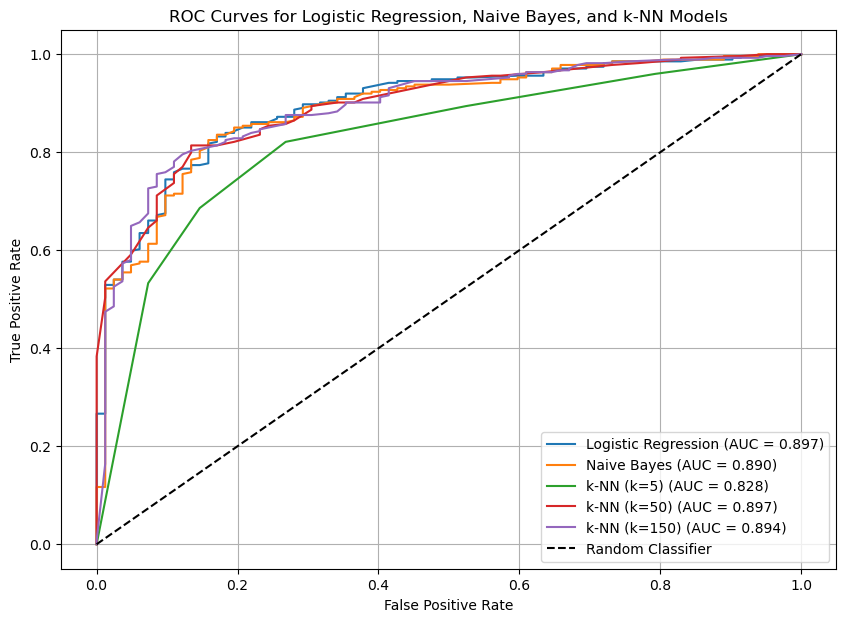

AUC Scores:
Logistic Regression: 0.897
Naive Bayes: 0.890
k-NN (k=5): 0.828
k-NN (k=50): 0.897
k-NN (k=150): 0.894

Model with highest AUC: Logistic Regression (0.897)


In [137]:
# part h

#binary encoding: CH=1, MM=0
sig_vars = ['LoyalCH', 'PriceDiff']

X_train = train[sig_vars]
y_train = (train['Purchase'] == 'CH').astype(int)

X_test = test[sig_vars]
y_test = (test['Purchase'] == 'CH').astype(int)

#Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
prob_log = log_model.predict_proba(X_test)[:, 1]

#Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
prob_nb = nb_model.predict_proba(X_test)[:, 1]

#k-nearest neighbors models
knn_probs = {}
for k in [5, 50, 150]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    prob_knn = knn.predict_proba(X_test)[:, 1]  # probability of CH
    knn_probs[k] = prob_knn

#ROC curves and AUC
models = {
    'Logistic Regression': prob_log,
    'Naive Bayes': prob_nb,
    'k-NN (k=5)': knn_probs[5],
    'k-NN (k=50)': knn_probs[50],
    'k-NN (k=150)': knn_probs[150]
}

plt.figure(figsize=(10, 7))
auc_scores = {}

for name, prob in models.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    auc_scores[name] = auc
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression, Naive Bayes, and k-NN Models')
plt.legend()
plt.grid(True)
plt.show()

print("AUC Scores:")
for name, auc in auc_scores.items():
    print(f"{name}: {auc:.3f}")

#find best model by AUC
best_model = max(auc_scores, key=auc_scores.get)
print(f"\nModel with highest AUC: {best_model} ({auc_scores[best_model]:.3f})")

# Question 3

In [138]:
#Observations data
X = [[1, 4],
    [1, 3],
    [0, 4],
    [5, 1],
    [6, 2],
    [4, 0]]

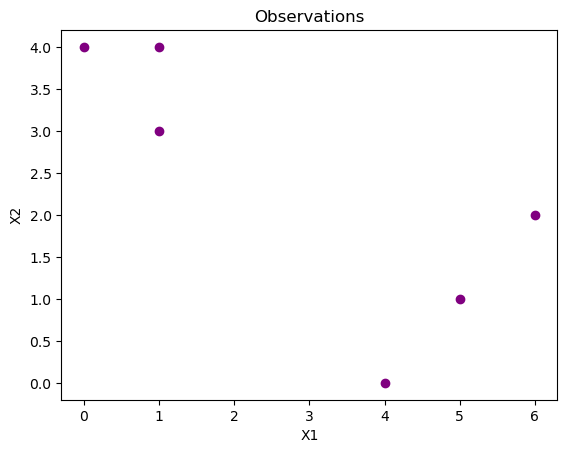

In [139]:
# part a

#put into separate lists for plotting
x1 = [point[0] for point in X]
x2 = [point[1] for point in X]

#making scatterplot
plt.scatter(x1, x2, color='purple')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Observations')
plt.show()

In [140]:
# part b

#number of clusters and observations
K = 2
n = 6

#randomly assign clusters to each observation
cluster_labels = np.random.choice(K, size=n)

#show cluster labels
for i, label in enumerate(cluster_labels, start=1):
    print(f"Observation {i}: Cluster {label}")


Observation 1: Cluster 1
Observation 2: Cluster 0
Observation 3: Cluster 0
Observation 4: Cluster 0
Observation 5: Cluster 1
Observation 6: Cluster 1


In [141]:
# part c

#convert X to a numpy array
X = np.array(X)

#random clusters from part b
cluster_labels = np.array([0, 1, 1, 0, 0, 0])

#compute centroids
centroids = np.zeros((K, 2))
for k in range(K):      #K defined in part b
    cluster_points = X[cluster_labels == k]
    #get mean
    centroids[k] = cluster_points.mean(axis=0)

print("Centroids:")
for idx, centroid in enumerate(centroids):
    print(f"Cluster {idx}: {centroid}")

Centroids:
Cluster 0: [4.   1.75]
Cluster 1: [0.5 3.5]


In [142]:
# part d

#bring over centroids from part c
centroids = np.array([
    [4, 1.75],  
    [0.5, 3.5]   
])

#store new clusters
new_labels = np.zeros(n, dtype=int)

#compute Euclidean distance from point to centroid
for i in range(n):
    distances = np.linalg.norm(X[i] - centroids, axis=1) 
    new_labels[i] = np.argmin(distances)  

for i, label in enumerate(new_labels, start=1):
    print(f"Observation {i}: Cluster {label}")

Observation 1: Cluster 1
Observation 2: Cluster 1
Observation 3: Cluster 1
Observation 4: Cluster 0
Observation 5: Cluster 0
Observation 6: Cluster 0


In [143]:
# part e (part c again)

#random clusters from part b
cluster_labels = np.array([1, 1, 1, 0, 0, 0])

#compute centroids
centroids = np.zeros((K, 2))
for k in range(K):      #K defined in part b
    cluster_points = X[cluster_labels == k]
    #get mean
    centroids[k] = cluster_points.mean(axis=0)

print("Centroids:")
for idx, centroid in enumerate(centroids):
    print(f"Cluster {idx}: {centroid}")

Centroids:
Cluster 0: [5. 1.]
Cluster 1: [0.66666667 3.66666667]


In [144]:
# part e (part d again)

#bring over centroids from second part c
centroids = np.array([
    [5, 1],  
    [0.667, 3.667]   
])

#store new clusters
new_labels = np.zeros(n, dtype=int)

#compute Euclidean distance from point to centroid
for i in range(n):
    distances = np.linalg.norm(X[i] - centroids, axis=1) 
    new_labels[i] = np.argmin(distances)  

for i, label in enumerate(new_labels, start=1):
    print(f"Observation {i}: Cluster {label}")

Observation 1: Cluster 1
Observation 2: Cluster 1
Observation 3: Cluster 1
Observation 4: Cluster 0
Observation 5: Cluster 0
Observation 6: Cluster 0


## part e

The clusters assignments did not change so I can stop repeating part c and d.

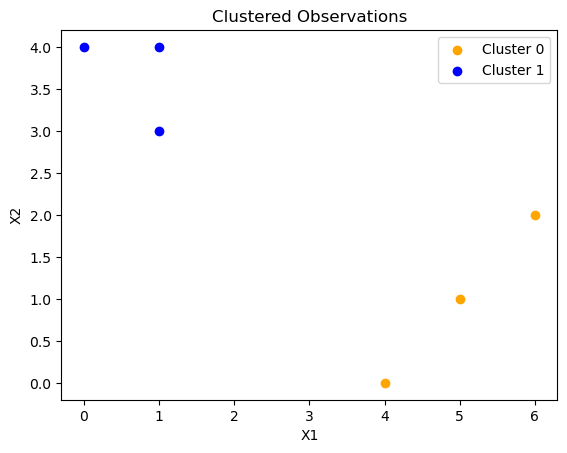

In [145]:
# part f

#final clusters from part e
cluster_labels = np.array([1, 1, 1, 0, 0, 0])

#make the scatter plot
colors = ['orange', 'blue']
for k in np.unique(cluster_labels):
    cluster_points = X[cluster_labels == k]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors[k], label=f'Cluster {k}')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Clustered Observations')
plt.legend()
plt.show()

# Question 4

In [146]:
#load the CEV2021 data set

CEV = pd.read_csv('../../data/CEV2021.csv')
CEV

,State,Formal_Volunteering,Organizational_Membership,Charitable_Giving,Voting_Local,Attending_Public_Meetings
0,AL,0.20,0.18,0.40,0.50,0.08
1,AK,0.27,0.26,0.48,0.67,0.14
2,AZ,0.23,0.23,0.49,0.59,0.06
3,AR,0.21,0.23,0.52,0.46,0.07
4,CA,0.18,0.18,0.39,0.58,0.08
5,CO,0.26,0.27,0.56,0.72,0.12
6,CT,0.29,0.22,0.61,0.57,0.10
7,DE,0.30,0.31,0.49,0.40,0.09
8,DC,0.34,0.36,0.61,0.78,0.14
9,FL,0.16,0.18,0.37,0.54,0.07


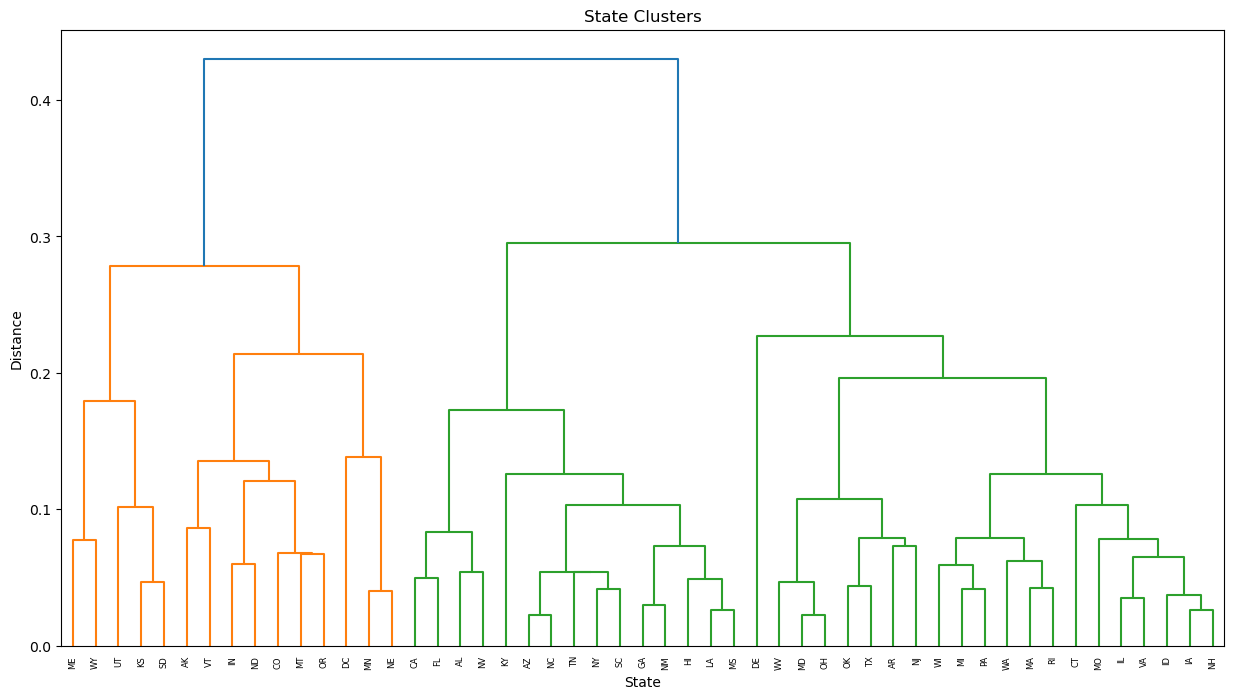

In [147]:
# part a 

#get rid of state column because we are using numerical values for this
data = CEV.drop(columns=['State'])

#hierarchical clustering with complete linkage and Euclidean distance
clusters = linkage(data, method='complete', metric='euclidean')

#dendrogram
plt.figure(figsize=(15, 8))
dendrogram(clusters, labels=CEV['State'].values)
plt.title('State Clusters')
plt.xlabel('State')
plt.ylabel('Distance')
plt.show()

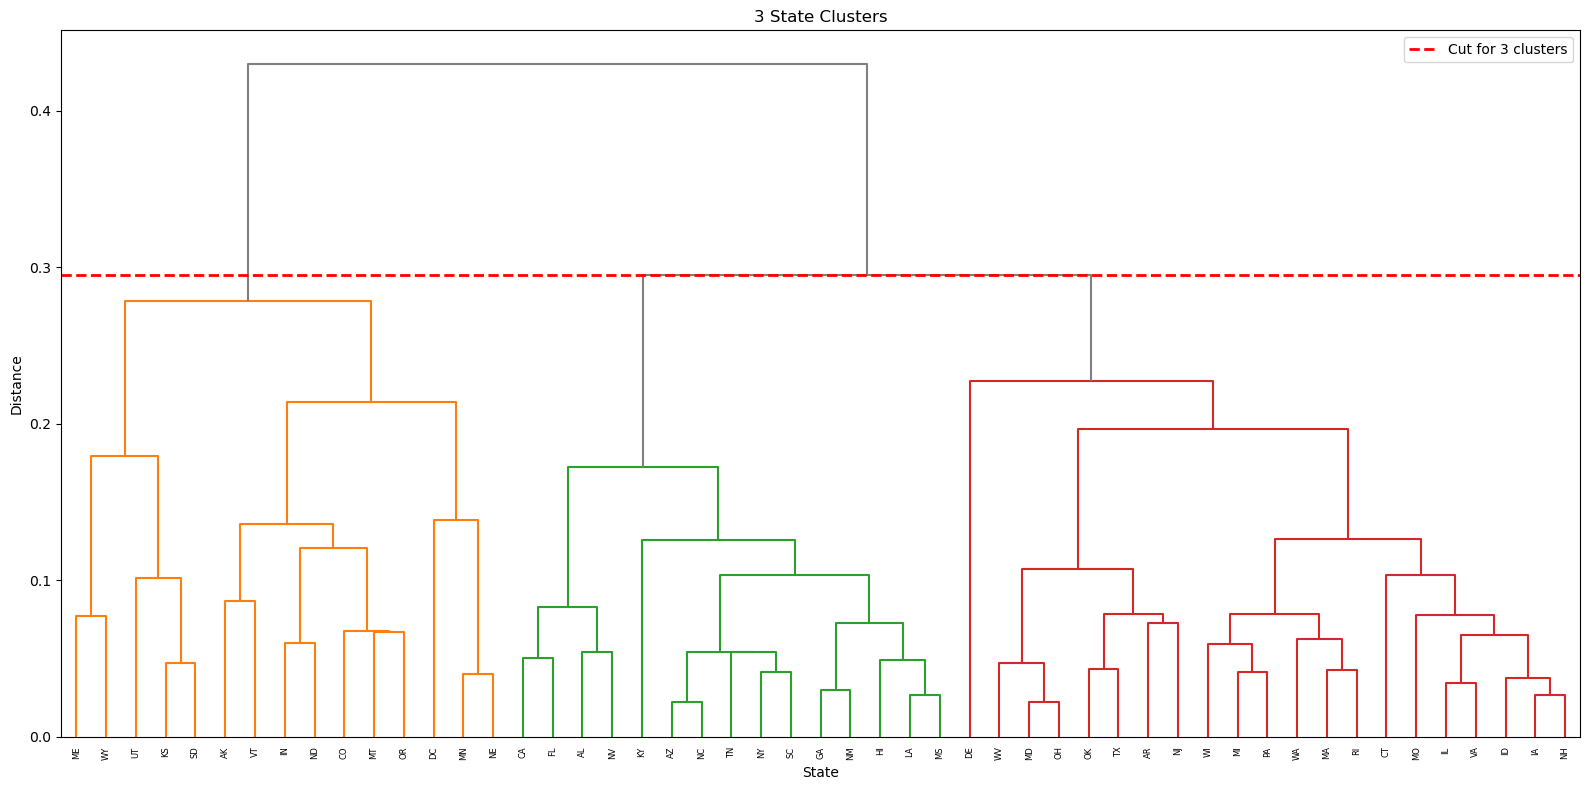

Cluster
1    [AK, CO, DC, IN, KS, ME, MN, MT, NE, ND, OR, S...
2    [AL, AZ, CA, FL, GA, HI, KY, LA, MS, NV, NM, N...
3    [AR, CT, DE, ID, IL, IA, MD, MA, MI, MO, NH, N...
Name: State, dtype: object


In [148]:
# part b

#cut dendrogram to form 3 clusters
Nclusters = fcluster(clusters, 3, criterion='maxclust')

#add cluster labels
CEV['Cluster'] = Nclusters

#find the height at which to cut the dendrogram
cut_height = clusters[-(3-1), 2] 

#dendrogram with
plt.figure(figsize=(16, 8))
dendro = dendrogram(
    clusters,
    labels=CEV['State'].values,
    leaf_rotation=90,
    color_threshold=cut_height,  
    above_threshold_color='gray' 
)

#add cut line
plt.axhline(y=cut_height, color='red', linestyle='--', linewidth=2, label='Cut for 3 clusters')

plt.title('3 State Clusters')
plt.xlabel('State')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()

clustered_states = CEV.groupby('Cluster')['State'].apply(list)
print(clustered_states)

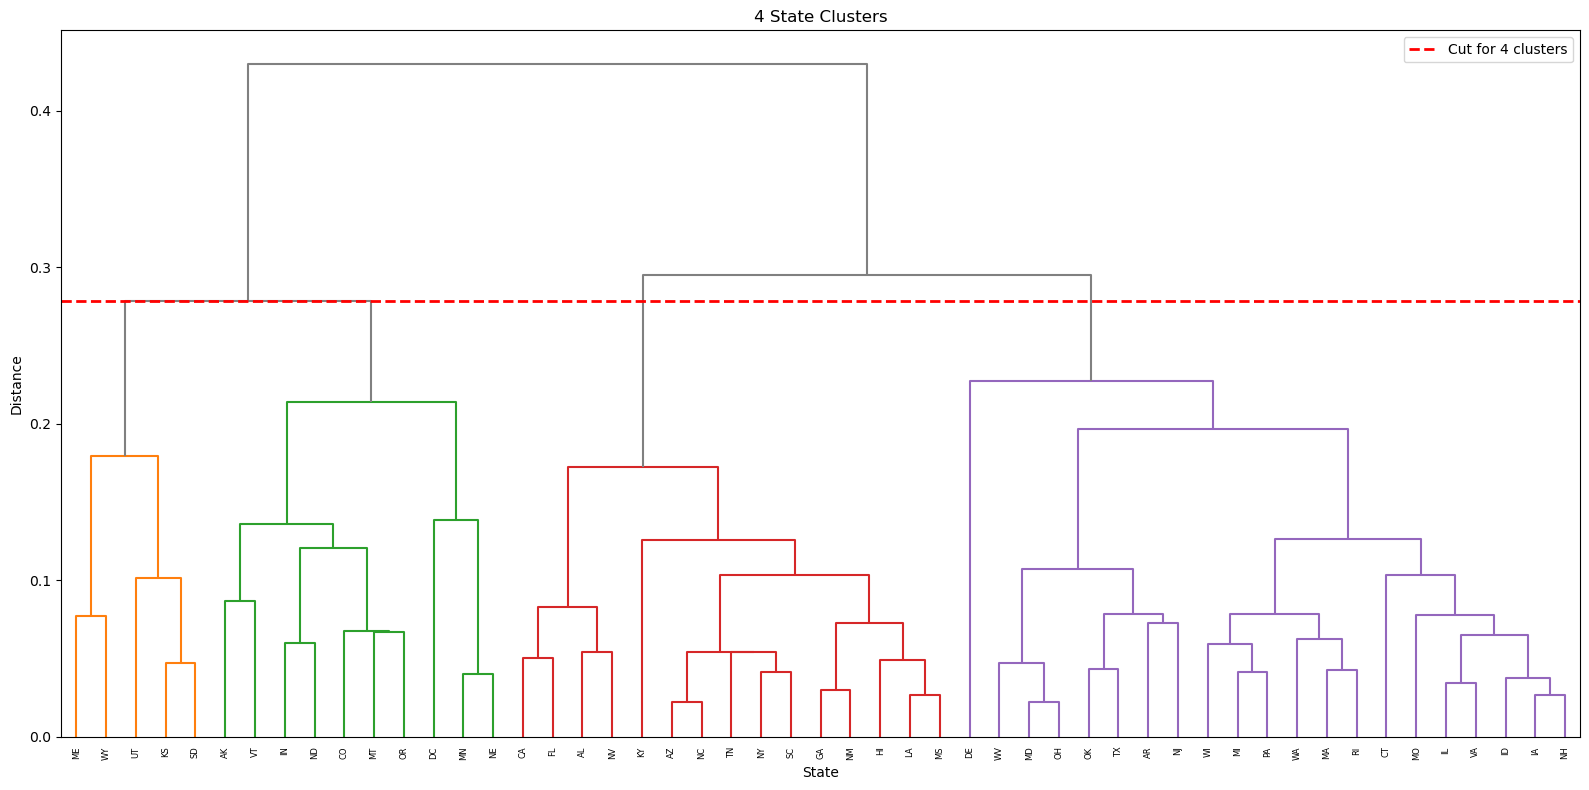

Cluster
1                                 [KS, ME, SD, UT, WY]
2             [AK, CO, DC, IN, MN, MT, NE, ND, OR, VT]
3    [AL, AZ, CA, FL, GA, HI, KY, LA, MS, NV, NM, N...
4    [AR, CT, DE, ID, IL, IA, MD, MA, MI, MO, NH, N...
Name: State, dtype: object


In [149]:
# part c

#Cut dendrogram to form 4 clusters
Nclusters = fcluster(clusters, 4, criterion='maxclust')
CEV['Cluster'] = Nclusters

#determine cut height 
cut_height = clusters[-(4 - 1), 2]

#dendrogram
plt.figure(figsize=(16, 8))
dendro = dendrogram(
    clusters,
    labels=CEV['State'].values,
    leaf_rotation=90,
    color_threshold=cut_height,
    above_threshold_color='gray'
)

#cut line
plt.axhline(y=cut_height, color='red', linestyle='--', linewidth=2, label='Cut for 4 clusters')

plt.title('4 State Clusters')
plt.xlabel('State')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()

# --- Show which states belong to which cluster ---
clustered_states = CEV.groupby('Cluster')['State'].apply(list)
print(clustered_states)

In [150]:
# part d

#get rid of state column because we are using numerical values for this
X = CEV.drop(columns=['State'])

#K-means clustering, K = 3
kmeans = KMeans(n_clusters=3, random_state=42)
CEV['KMeans_Cluster'] = kmeans.fit_predict(X)

#store new clusters
kmeans_clusters = CEV.groupby('KMeans_Cluster')['State'].apply(list)
print(kmeans_clusters)

KMeans_Cluster
0    [AK, CO, DC, IN, KS, ME, MN, MT, NE, ND, OR, S...
1    [AR, CT, DE, ID, IL, IA, MD, MA, MI, MO, NH, N...
2    [AL, AZ, CA, FL, GA, HI, KY, LA, MS, NV, NM, N...
Name: State, dtype: object


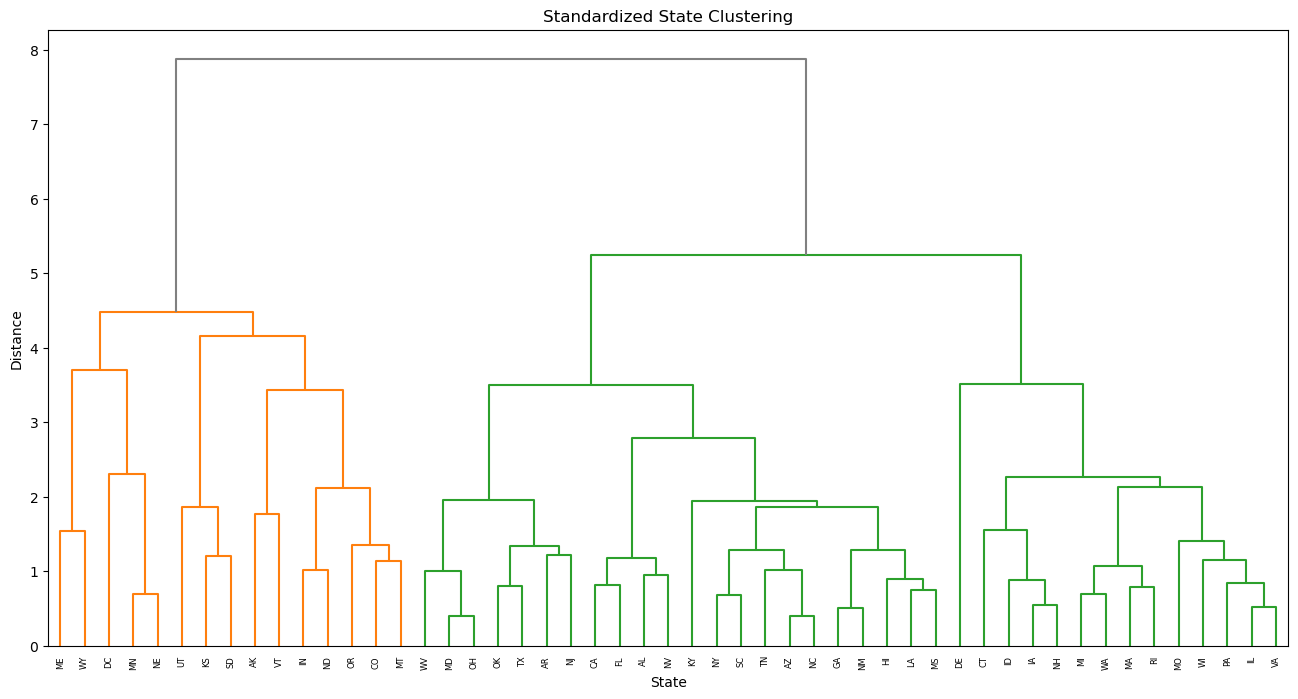

In [151]:
# part e

#rescale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(CEV.drop(columns=['State']))

#hierarchical clustering
C_scaled = linkage(X_scaled, method='complete', metric='euclidean')

#dendrogram
plt.figure(figsize=(16, 8))
dendrogram(
    C_scaled,
    labels=CEV['State'].values,
    leaf_rotation=90,
    above_threshold_color='gray'
)

plt.title('Standardized State Clustering')
plt.xlabel('State')
plt.ylabel('Distance')
plt.show()

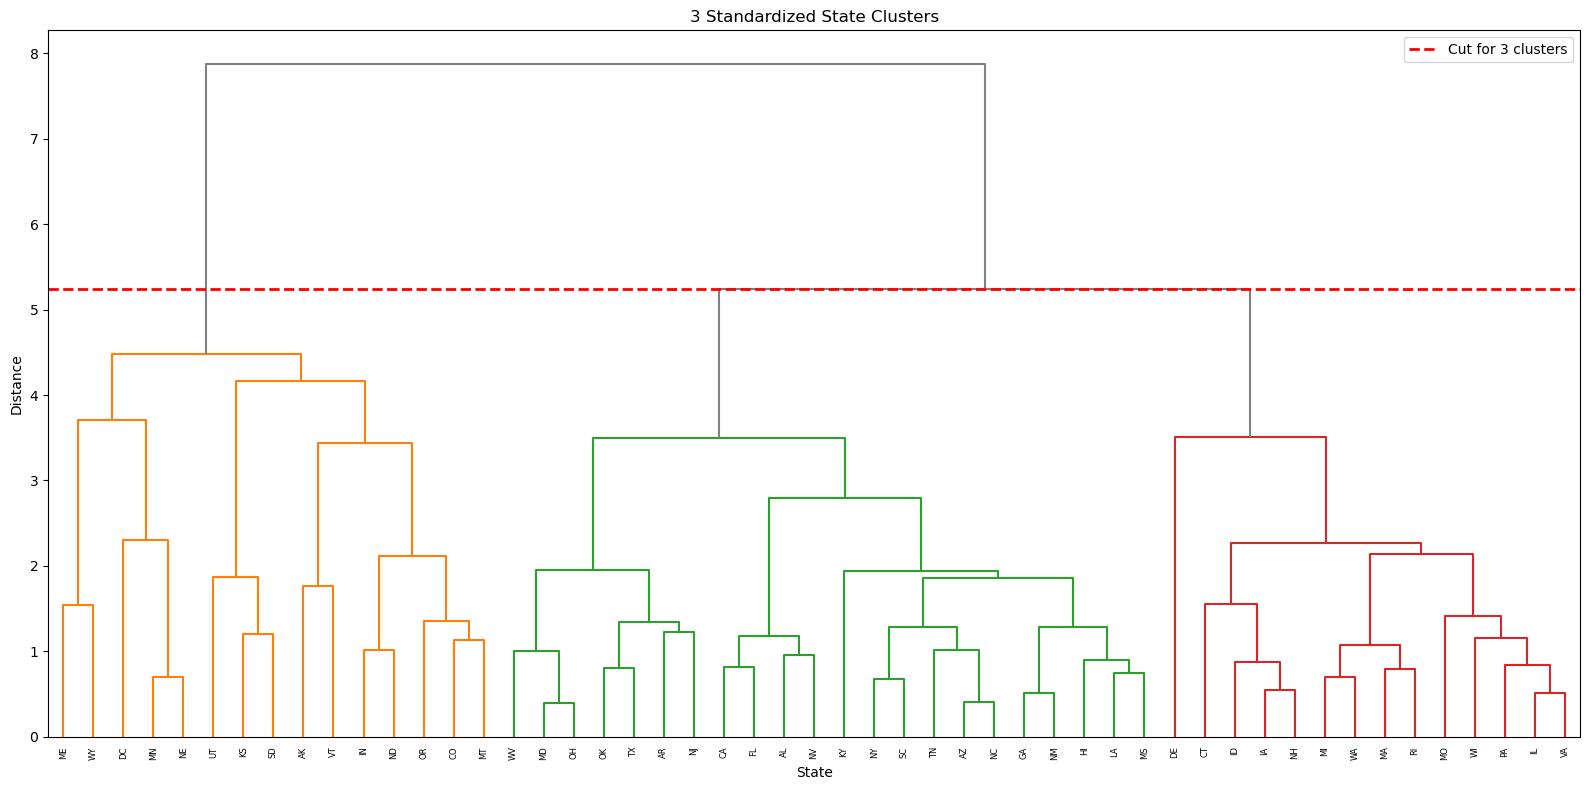

Cluster_z
1    [AK, CO, DC, IN, KS, ME, MN, MT, NE, ND, OR, S...
2    [AL, AZ, AR, CA, FL, GA, HI, KY, LA, MD, MS, N...
3    [CT, DE, ID, IL, IA, MA, MI, MO, NH, PA, RI, V...
Name: State, dtype: object


In [152]:
# part f

#cut dendrogram into 3 clusters
Nclusters_scaled = fcluster(C_scaled, 3, criterion='maxclust')
CEV['Cluster_z'] = Nclusters_scaled

#find cut height 
cut_height = C_scaled[-(3 - 1), 2]

#plot dendrogram with the red cut line
plt.figure(figsize=(16, 8))
dendro = dendrogram(
    C_scaled,
    labels=CEV['State'].values,
    leaf_rotation=90,
    color_threshold=cut_height,
    above_threshold_color='gray'
)
plt.axhline(y=cut_height, color='red', linestyle='--', linewidth=2, label='Cut for 3 clusters')

plt.title('3 Standardized State Clusters')
plt.xlabel('State')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()

clustered_states_z = CEV.groupby('Cluster_z')['State'].apply(list)
print(clustered_states_z)

In [153]:
# part g

#drop the "State" variable because we are using numerical values only
X_scaled = scaler.fit_transform(CEV.drop(columns=['State']))

#K-means clustering with K = 3
kmeans_scaled = KMeans(n_clusters=3, random_state=42)
CEV['KMeans_Cluster_c'] = kmeans_scaled.fit_predict(X_scaled)

kmeans_clusters_c = CEV.groupby('KMeans_Cluster_c')['State'].apply(list)
print("\nStates in Each K-means Cluster (Standardized Data, K=3):\n")
print(kmeans_clusters_c)


States in Each K-means Cluster (Standardized Data, K=3):

KMeans_Cluster_c
0    [AK, CO, DC, IN, KS, ME, MN, MT, NE, ND, OR, S...
1    [CT, DE, ID, IL, IA, MA, MI, MO, NH, PA, RI, V...
2    [AL, AZ, AR, CA, FL, GA, HI, KY, LA, MD, MS, N...
Name: State, dtype: object


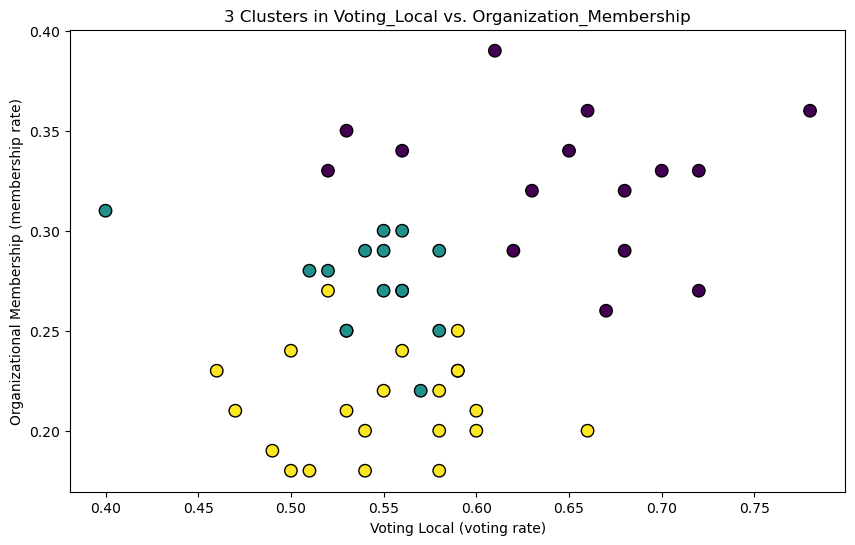

In [154]:
# part h

#make scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(
    CEV['Voting_Local'],
    CEV['Organizational_Membership'],
    c=CEV['KMeans_Cluster_c'],
    cmap='viridis',
    s=80,
    edgecolor='black'
)
plt.title('3 Clusters in Voting_Local vs. Organization_Membership')
plt.xlabel('Voting Local (voting rate)')
plt.ylabel('Organizational Membership (membership rate)')

plt.show()